# Visualizing what the network focuses on

Once we trained our networks, we would like to understand what they focus on, so what are the input zones that are considered the most in order to make them take the decision of which class to assign to the samples. 

To do that, we are going to consider two of the previous networks that performed best(namely Bigger Aggressive-Downsampling CNN and CNN with Inception Layers) and we are going to visualize their **heatmap** of the class activations applied to a test sample, but also what is the accuracy if we apply some **occlusion mask**, i.e. we apply grey squares to cover portions of the input image, visualizing if the system is still able to predict the correct class.

## Heatmap visualization

In [1]:
import tensorflow as tf
import tensorflow.keras as ks
import os
import numpy as np
from IPython.display import display

In [2]:
models_path="/content/drive/Shareddrives/CIDL/project/models/CNN"
bigger_aggressive_downsampling_path = os.path.join(models_path, "BiggerAggressiveDownsamplingCNN.h5")
inception_layers_CNN_path = os.path.join(models_path, "InceptionLayerCNN.h5")

ad_model = ks.models.load_model(bigger_aggressive_downsampling_path)
il_model = ks.models.load_model(inception_layers_CNN_path)

In [3]:
ad_model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_34 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 4, 4, 128)        0         
 g2D)                                                     

In [4]:
il_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_30 (Rescaling)       (None, 224, 224, 3)  0           ['input_31[0][0]']               
                                                                                                  
 conv2d_126 (Conv2D)            (None, 56, 56, 32)   896         ['rescaling_30[0][0]']           
                                                                                                  
 max_pooling2d_84 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_126[0][0]']      

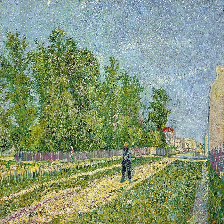

In [5]:
test_img_path = '/content/drive/Shareddrives/CIDL/project/visualization/Vincent_van_Gogh_18.jpg'
test_img = ks.utils.load_img(test_img_path, target_size=(224, 224))

def get_img_array(img):
    array = ks.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

display(test_img)
img_array = get_img_array(test_img)

In [6]:
classes = ['Alfred Sysley', 'Edgar Degas', 'Francisco Goya', 'Marc Chagall', 'Pablo Picasso', 'Paul Gauiguin', 'Pierre-August Renoir', 'Rembrandt', 'Titian', 'Vincent Van Gogh']
result_ad = classes[np.argmax(ad_model.predict(img_array))]
result_ad

'Vincent Van Gogh'

In [7]:
result_il = classes[np.argmax(il_model.predict(img_array))]
result_il

'Vincent Van Gogh'

In [8]:
ad_layer_name = 'conv2d_104'
il_layer_name = 'conv2d_131'

In [ ]:
ad_conv_layer = ad_model.get_layer(ad_layer_name)
ad_conv_layer_model = ks.Model(ad_model.inputs, ad_conv_layer.output)
il_conv_layer = il_model.get_layer(il_layer_name)
il_conv_layer_model = ks.Model(il_model.inputs, il_conv_layer.output)

In [ ]:
ad_layer_names = ['flatten_34', 'dense_43', 'dense_44', 'predictions']
il_layer_names = ['flatten_30', 'dense_19', 'predictions']

ad_classifier_input = ks.Input(shape=ad_conv_layer.output.shape[1:])
x = ad_classifier_input
for layer_name in ad_layer_names:
    x = ad_model.get_layer(layer_name)(x)
ad_classifier_model = ks.Model(ad_classifier_input, x)

il_classifier_input = ks.Input(shape=il_conv_layer.output.shape[1:])
x = il_classifier_input
for layer_name in il_layer_names:
    x = il_model.get_layer(layer_name)(x)
il_classifier_model = ks.Model(il_classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
    ad_conv_layer_output = ad_conv_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(ad_conv_layer_output)
    preds = ad_classifier_model(ad_conv_layer_output)  
    top_pred_index = tf.argmax(preds[0])  
    top_class_channel = preds[:, top_pred_index] 
    print(top_pred_index)
    print(top_class_channel)

ad_grads = tape.gradient(top_class_channel, ad_conv_layer_output)

with tf.GradientTape() as tape:
    il_conv_layer_output = il_conv_layer_model(img_array) # output feature maps of the last conv layer.
    tape.watch(il_conv_layer_output)
    preds = il_classifier_model(il_conv_layer_output)  
    top_pred_index = tf.argmax(preds[0])  
    top_class_channel = preds[:, top_pred_index] 
    print(top_pred_index)
    print(top_class_channel)

il_grads = tape.gradient(top_class_channel, il_conv_layer_output)

tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor([0.86037236], shape=(1,), dtype=float32)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor([0.86704427], shape=(1,), dtype=float32)


In [ ]:
ad_pooled_grads = tf.reduce_mean(ad_grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
weighted_ad_conv_layer_output = ad_conv_layer_output.numpy()[0]
for i in range(ad_pooled_grads.shape[-1]):
    weighted_ad_conv_layer_output[:, :, i] *= ad_pooled_grads[i]

il_pooled_grads = tf.reduce_mean(il_grads, axis=(0, 1, 2)).numpy() 
weighted_il_conv_layer_output = il_conv_layer_output.numpy()[0]
for j in range(il_pooled_grads.shape[-1]):
    weighted_il_conv_layer_output[:, :, j] *= il_pooled_grads[j]    

In [ ]:
ad_temp_heatmap = np.mean(weighted_ad_conv_layer_output, axis=-1)
il_temp_heatmap = np.mean(weighted_il_conv_layer_output, axis=-1)

In [ ]:
temp_ad_heatmap = np.maximum(ad_temp_heatmap, 0)
ad_heatmap = ad_temp_heatmap/np.max(temp_ad_heatmap)
temp_il_heatmap = np.maximum(il_temp_heatmap, 0)
il_heatmap = il_temp_heatmap/np.max(temp_il_heatmap)

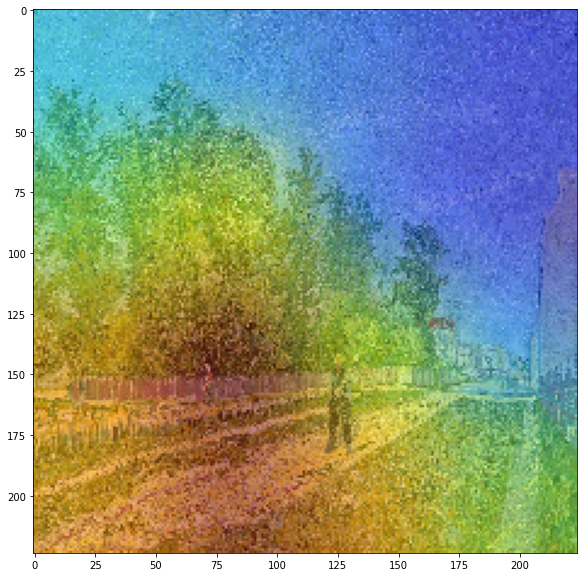

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


heatmap = np.uint8(255 * ad_heatmap)

img = ks.utils.img_to_array(test_img)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = ks.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = ks.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.8 + img
superimposed_img = ks.utils.array_to_img(superimposed_img)


plt.figure(figsize= (10,10))
plt.imshow(superimposed_img)

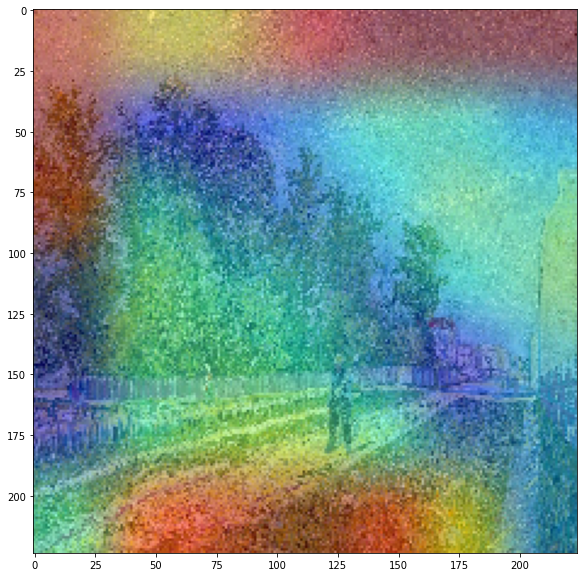

In [ ]:
heatmap = np.uint8(255 * il_heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = ks.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = ks.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.8 + test_img
superimposed_img = ks.utils.array_to_img(superimposed_img)

plt.figure(figsize= (10,10))
plt.imshow(superimposed_img)

## Considerations

Aggressive downsampling networks tends to "look" at the center of the image in order to classify it, observing at the color distribution in the middle of it.

On the contrary the Network with inception layers considers the borders of the image, looking for characteristic feautures on the background.


## Occlusion masks

Disclaimer: this code is readapted from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps, "Simple occlusion and saliency map" by Peter Grenholm.

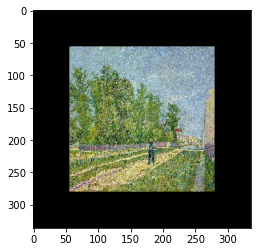

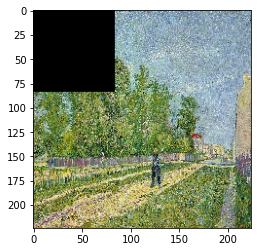

Vincent Van Gogh -- Vincent Van Gogh


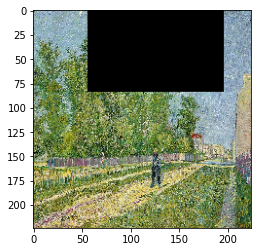

Vincent Van Gogh -- Alfred Sysley


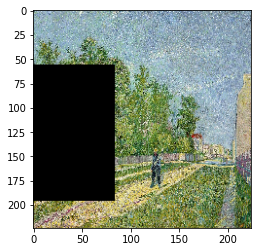

Vincent Van Gogh -- Vincent Van Gogh


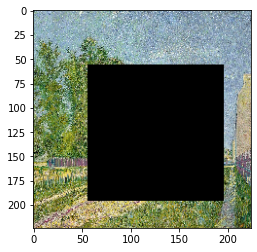

Vincent Van Gogh -- Rembrandt


First model accuracy was 1.000
Second model accuracy was 0.500


In [ ]:
from skimage import color
from skimage import io
size=28
#size=35
#size=10
correct_class='Vincent Van Gogh'
correct_answers_ad=0
correct_answers_il=0
counter=0
image = test_img
occlusion = np.full((size * 5, size * 5, 3), [0.5], np.float32) 
occlusion_center = np.full((size, size, 1), [0.5], np.float32)
occlusion_padding = size * 2

# we apply 0 padding to the original image, to better estimate the error given by the occlusion of the corners
image_padded = np.pad(
                        image, 
                        (
                          (occlusion_padding, occlusion_padding), 
                          (occlusion_padding, occlusion_padding), 
                          (0, 0)
                        ),
                        'constant', 
                        constant_values = 0.0
                      )
plt.imshow(image_padded)

img_array = ks.utils.img_to_array(image)
for y in range(occlusion_padding, 224+occlusion_padding, size*4):

    for x in range(occlusion_padding, 224+occlusion_padding, size*4):
        counter+=1
        tmp = image_padded.copy()
        
        tmp[y - occlusion_padding:y + size + occlusion_padding, x - occlusion_padding:x + size + occlusion_padding]= occlusion

        tmp[y:y + size, x:x + size] = occlusion_center
        tmp = tmp[occlusion_padding:-occlusion_padding, occlusion_padding:-occlusion_padding, :]

        plt.figure()
        plt.imshow(ks.utils.array_to_img(tmp))
        plt.show()

        tmp = np.expand_dims(tmp, axis=0)
        prediction_ad = classes[np.argmax(ad_model.predict(tmp))] 
        prediction_il = classes[np.argmax(il_model.predict(tmp))]
        print(prediction_ad, "--", prediction_il)  
        if prediction_ad == correct_class:
          correct_answers_ad+=1
        if prediction_il == correct_class:
          correct_answers_il+=1

print(f"\n\nFirst model accuracy was {correct_answers_ad/counter:.3f}")
print(f"Second model accuracy was {correct_answers_il/counter:.3f}")
